<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-03/Nassisi_3_Radiation_pulse_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-03/Nassisi_3_Radiation_pulse_analysis.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# Radiation pulse analysis

The analysis notebook relies on the "Nuclear particle master" sheet to provide timestamps for different phases of an experiment in order to perform bin-independent radiation analysis.

The aim is to develop techniques to characterise the background and detect anomalies in a way that minimises numerical artifiacts.


### Nassisi 3
The third Nassisi style experiment ran from April 4 to June 20, 2025 in chamber #3. A 15.4 cm Pd wire was coiled and placed in 3.20 bar absolute pressure of D2 gas for one month. Then, the chamber was evacuated and vented to atmosphere, before being resealed and repressurized with 2.34 bar absolute pressure of D2, followed by exposure to a UV pulsed laser for one hour a day for one month.

This notebook analyzes the neutron emission during this time period as measured by a 2" Eljen detector placed just outside the chamber.

In [1]:
experiment_id = 6

## Libraries

In [2]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Interacting with sheets
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text
from scipy.stats import kstest


#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

## Authentication

We need to do a few authentication steps:
- Bring in the database credentials from Google drive so that we can pull data from the live database.
- Bring in the nuclear particle master sheet ID
-  Authenticate Colab to pull the nuclear particle master sheet using the Drive API.

In [3]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Mounted at /content/drive


In [4]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [5]:
# Authenticate using Colab's built-in credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Extracting experimental timestamps

We need to
- Open the master sheet
- Find the row corresponding with the experiment
- Extract the timestamp columns

In [6]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df = pd.DataFrame(sheet.get_all_records())

In [7]:
# Find the row where Experiment ID matches
row = df[df['Experiment ID'] == experiment_id]

# Exract digitizer, either 4 channel or 8
digitizer = 8 #row["Digitizer"].iloc[0]

# Extract the channel number
channel_number = row["Digitizer channel number"].iloc[0]

# Extract the psp neutron/gamma discriminator
psp = row["psp threshold"].iloc[0]

# Extract times
times = row[['Setup', 'Calibration', 'Background 1', 'Experiment', 'Background 2', 'End']]

times = times.apply(pd.to_datetime)

# Display the extracted times
times.head()

,Setup,Calibration,Background 1,Experiment,Background 2,End
10,NaT,2025-04-04 16:45:00,2025-04-04 17:11:00,2025-04-04 17:35:00,2025-06-06 12:00:00,2025-06-20 12:00:00


## Pulling the radiation events

We store each individual radiation pulse in our database. These pulses are characterised by an energy and a psp value. The radiation pulses contain a mixture of gamma and neutron events which can be distinguised through PSD analysis at different levels of sophistication.

The [simplest PSD analysis](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD_Analysis.ipynb) is to use a PSP discriminator value above which the pulses are considered to be neutrons, below are gammas. We can also combine this with an similar energy discriminator.

We can then query the database to pull only the events that match our PSD analysis requirements.

In [8]:
def get_event_data(start_time, end_time, psp=">0", energy=">0"):
  query = f"""
  SELECT * FROM caen{digitizer}ch_ch{channel_number}
  WHERE channels[1] {psp} AND channels[2] {energy}
  AND time BETWEEN '{start_time}' AND '{end_time}'
  ORDER BY time;
  """
  df = pd.read_sql(query, engine, index_col=None)
  df.set_index('time', inplace=True)
  return df

We'll can now get all the event data for the different periods in the experiement.

In [9]:
def get_all_event_data(times, psp=">0", energy=">0"):
  event_data = {}
  event_periods = {}
  columns = times.columns  # Include all columns, including 'Setup'

  for i in range(len(columns) - 1):  # Stop before the last column
      start_time = times.iloc[0, i]
      if pd.notna(start_time):
          # Find the next non-empty time
          end_time = None
          for j in range(i + 1, len(columns)):
              if pd.notna(times.iloc[0, j]):
                  end_time = times.iloc[0, j]
                  break
          # Only proceed if a valid end_time was found
          if end_time is not None:
              data = get_event_data(start_time, end_time, psp, energy)
              event_data[columns[i]] = data
              event_periods[columns[i]] = end_time - start_time

  return event_data, event_periods

## Neutron background analysis

We're going to look at the neutron events during the background phase of the experiment and perform an analysis to characterise the background. Often, analysis of this kind is performed by "binning" the data and looking at counts per second/minute/hour. While it is often more intuitive to view the radiation rates, in our analysis we will take a bin-indepedent view by analysing the time in between neutron events. This way, we avoid any artifacts of binning.

We can extract only the neutron events by using the psp values stored in the master spreadsheet.

In [10]:
psp

0.171

In [11]:
#Set energy cutoff in channels
energy = 500

In [12]:
neutron_data, neutron_periods = get_all_event_data(times, f">{psp}", f">{energy}")

### Reconstructing the pulses

Let's see what the pulse data looks like for the background.

In [13]:
neutron_data["Background 1"].head()

,channels,ps,id
time,,,
2025-04-04 17:12:49.307102,"[0.21314102564102563, 624.0]",307101726531,3184053
2025-04-04 17:19:00.189991,"[0.1819148936170213, 1880.0]",189991474151,3193089
2025-04-04 17:19:21.597904,"[0.6410537870472008, 911.0]",597903728485,3193620
2025-04-04 17:20:45.457314,"[0.19699646643109542, 1132.0]",457313537597,3195646


The `channels` column gives `[psp, energy]`.

The database timestamp is limited in precision to microseconds, so we store the full picosecond precision in the `ps` columm. We therefore need to combine the time in microseconds with the picosecond time piece. It turns out that pandas only does datetime to nanoseconds so we'll have to discard some precision.

In [14]:
def reconstruct_ns_pulses(df):
  # Floor the index to strip microseconds
  df.index = df.index.floor('s')

  # Convert picoseconds to nanoseconds
  df['ps_ns'] = df['ps'] // 1_000  # convert ps → ns

  # Create high-resolution timestamp
  df['timestamp'] = df.index + pd.to_timedelta(df['ps_ns'], unit='ns')

  # Set timestamp as index
  df.set_index('timestamp', inplace=True)

  # Create 'counts' column with value 1 for each row
  df['counts'] = 1

  # Drop all unneeded columns (including 'channels')
  df.drop(columns=['id', 'ps', 'ps_ns', 'channels'], inplace=True)

  # Sort by timestamp index
  df.sort_index(inplace=True)

  return df

We'll now reconstruct the nanosecond pulses for all the experimental periods.

In [15]:
for key, value in neutron_data.items():
  neutron_data[key] = reconstruct_ns_pulses(value)

### Inter-pulse distribution

During the background phase of the experiment, we expect to measure radiation pulses randomly over time - following a Poisson distribution.

For a Poisson process occuring at an average rate of $\lambda$, the probability that the time between events $\Delta t$ is less than some time $t$ is given by:

$$
P_{\rm Poisson}(\Delta t \le t) = 1 - e^{-\lambda t}
$$

We can estimate the $\lambda$ from the experimetnally derived average inter-pulse time $\overline{\Delta t}$ via:

$$
\lambda = \frac{1}{\overline{\Delta t}}
$$

In [16]:
background = neutron_data["Background 1"]

In [17]:
deltas = np.diff(background.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
delta_sorted = np.sort(deltas)

In [18]:
# Estimate lambda (rate in events per second)
lam = 1 / np.mean(delta_sorted)

# Calculate the theoretical distribution
P_poisson = 1 - np.exp(-lam * delta_sorted)

We've now got the theoretical inter-pulse distribution based on the assumption that the system indeed behaves like a Poisson process. How does the system really behave?

We need to calculate the cumulative distribution of events in order to compare with the Poisson probability distribution.

$$
P_{\rm exp}(\Delta t \le t) = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}\bigl(\Delta t_i \le t\bigr)
$$

In [19]:
P_exp = np.arange(1, len(delta_sorted) + 1) / len(delta_sorted)

Let's see how the Poisson distribution compares to the experimental one.

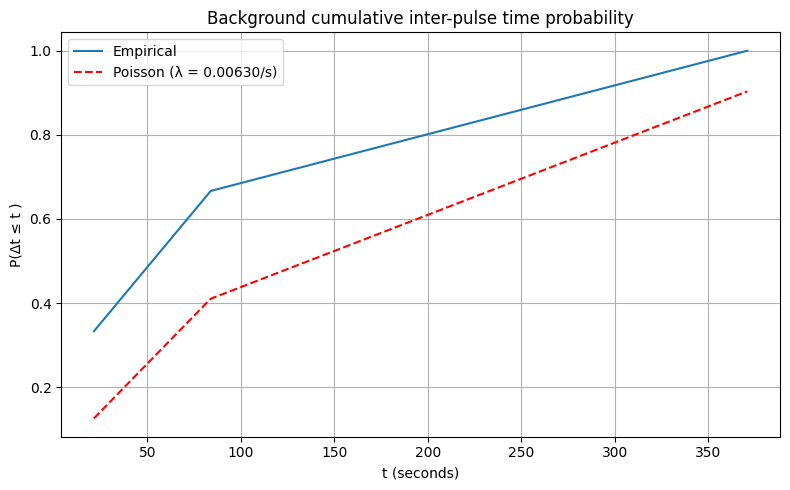

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(delta_sorted, P_exp, label="Empirical")
plt.plot(delta_sorted, P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {lam:.5f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
plt.title("Background cumulative inter-pulse time probability")
#plt.xlim([0,30])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**TODO: Statistical test**

Let's also check the second background period, which was also taken in 13-3100, but for several days.

In [21]:
background2 = neutron_data["Background 2"]

In [22]:
background2_deltas = np.diff(background2.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
background2_delta_sorted = np.sort(background2_deltas)

In [23]:
# Estimate lambda (rate in events per second)
background2_lam = 1 / np.mean(background2_delta_sorted)

# Calculate the theoretical distribution
background2_P_poisson = 1 - np.exp(-background2_lam * background2_delta_sorted)

background2_P_exp = np.arange(1, len(background2_delta_sorted) + 1) / len(background2_delta_sorted)

In [24]:
background2_lam

np.float64(0.0012934611368412873)

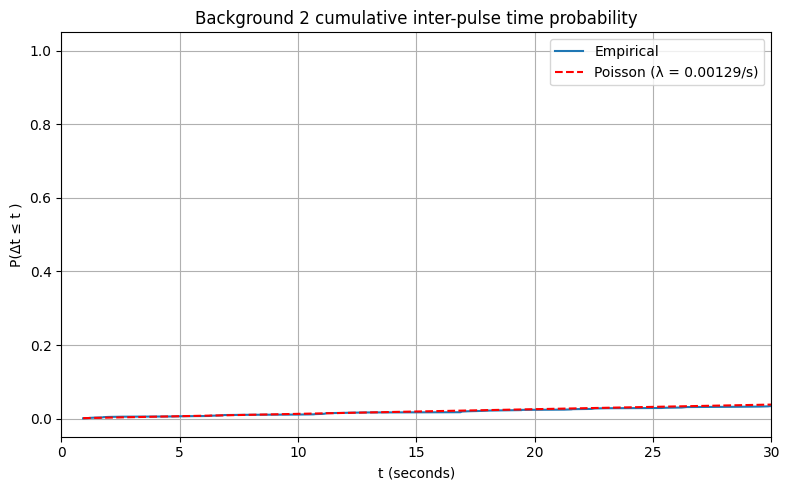

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(background2_delta_sorted, background2_P_exp, label="Empirical")
plt.plot(background2_delta_sorted, background2_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {background2_lam:.5f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
plt.title("Background 2 cumulative inter-pulse time probability")
plt.xlim([0,30])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Run KS test against an exponential distribution with estimated lambda
ks_stat, p_value = kstest(synthetic_deltas_sorted, 'expon', args=(0, 1/lam))

ks_stat, p_value

In [26]:
# # Run KS test against an exponential distribution with estimated lambda
# ks_stat, p_value = kstest(synthetic_deltas_sorted, 'expon', args=(0, 1/lam))

# ks_stat, p_value

It's instructive to look at the cumulative pulses alongside the counts per minute.

In [27]:
background_cpm = background.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Counts per min", x=background_cpm.index, y=background_cpm.counts))

## Anomaly detection

We can use the inter-pulse cumulative probability to detect deviations from normal background, aka anomalies.

In [28]:
neutron_periods["Experiment"]

Timedelta('62 days 18:25:00')

In [29]:
experiment = neutron_data["Experiment"]
experiment_deltas = np.diff(experiment.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
experiment_delta_sorted = np.sort(experiment_deltas)

In [30]:
# Estimate lambda for experiment period (rate in events per second)
experiment_lam = 1 / np.mean(experiment_delta_sorted)

# Calculate the theoretical distribution
experiment_P_poisson = 1 - np.exp(-experiment_lam * experiment_delta_sorted)

experiment_P_exp = np.arange(1, len(experiment_delta_sorted) + 1) / len(experiment_delta_sorted)

In [31]:
experiment_lam

np.float64(0.001205985415276123)

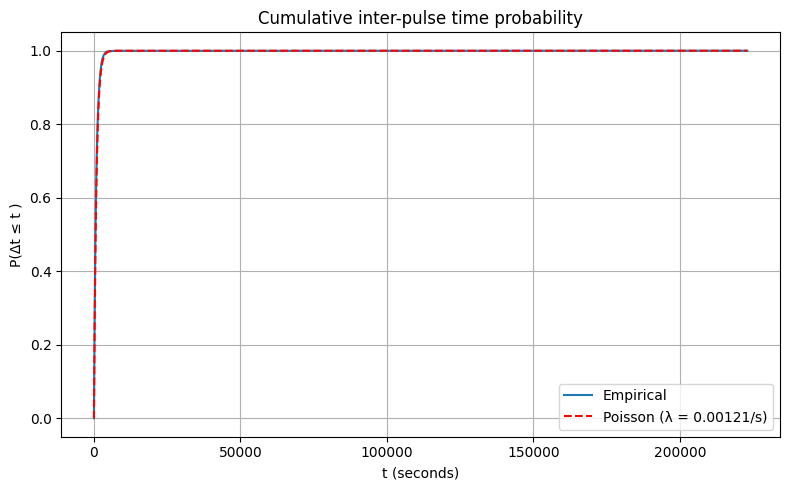

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(experiment_delta_sorted, experiment_P_exp, label="Empirical")
plt.plot(experiment_delta_sorted, experiment_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {experiment_lam:.5f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
#plt.xlim([0,30])
plt.title("Cumulative inter-pulse time probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
neutron_periods["Background 1"]

Timedelta('0 days 00:24:00')

In [34]:
# Run KS test against an exponential distribution with estimated lambda
ks_stat, p_value = kstest(experiment_delta_sorted, 'expon', args=(0, 1/experiment_lam))

ks_stat, p_value

(np.float64(0.03740553144999048), np.float64(2.1994630116893446e-08))

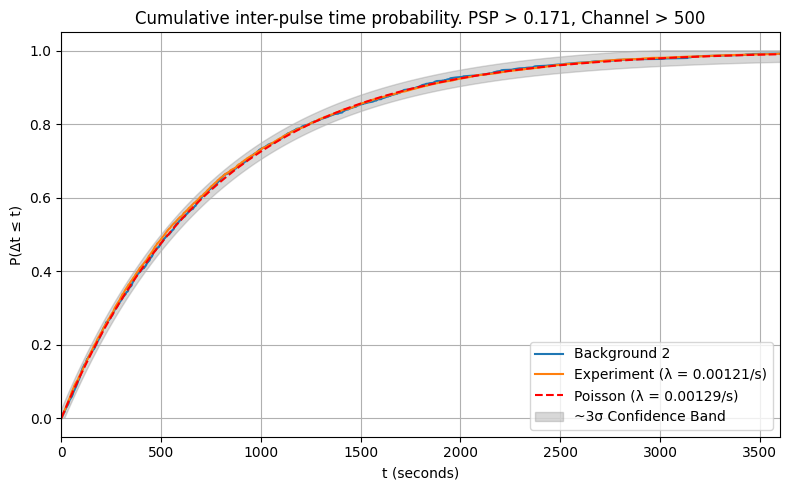

In [35]:
# Number of samples (n)
n = len(experiment_delta_sorted)

# Desired confidence level (e.g. ~3σ = 99.7%)
alpha = 0.003

# Kolmogorov–Smirnov critical value for given alpha and n
D_alpha = np.sqrt(-0.5 * np.log(alpha / 2) / n)


# Upper and lower bounds of the confidence band
upper_bound = np.clip(background2_P_poisson + D_alpha, 0, 1)
lower_bound = np.clip(background2_P_poisson - D_alpha, 0, 1)

plt.figure(figsize=(8, 5))
plt.plot(background2_delta_sorted, background2_P_exp, label="Background 2")
plt.plot(experiment_delta_sorted, experiment_P_exp, label=f"Experiment (λ = {experiment_lam:.5f}/s)")
plt.plot(background2_delta_sorted, background2_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {background2_lam:.5f}/s)")
plt.fill_between(background2_delta_sorted, lower_bound, upper_bound, color='gray', alpha=0.3, label="~3σ Confidence Band", zorder=1)

# # Max deviation marker and vertical line
# plt.plot(t_max_dev, cdf_with_synthetic_neutrons[max_index], 'ko', label="KS Statistic (D)")
# plt.vlines(t_max_dev, P_theory_at_synth[max_index], cdf_with_synthetic_neutrons[max_index], color='k', linestyles='dotted')

# # Annotate
# plt.annotate(f"D = {ks_statistic:.4f}", xy=(t_max_dev, cdf_with_synthetic_neutrons[max_index]),
#              xytext=(t_max_dev + 0.2, cdf_with_synthetic_neutrons[max_index] + 0.01),
#              arrowprops=dict(arrowstyle="->", lw=1), fontsize=9)

# Recompute bounds for synthetic burst dataset
#n_synth = len(synthetic_deltas_sorted)
#D_alpha_synth = np.sqrt(-0.5 * np.log(alpha / 2) / n_synth)
#P_poisson_synth = 1 - np.exp(-lam * synthetic_deltas_sorted)
#upper_bound_synth = np.clip(P_poisson_synth + D_alpha_synth, 0, 1)
#lower_bound_synth = np.clip(P_poisson_synth - D_alpha_synth, 0, 1)

#first_cross_index = np.argmax(
#    (cdf_with_synthetic_neutrons > upper_bound_synth) |
#    (cdf_with_synthetic_neutrons < lower_bound_synth)
#)

#plt.axvline(synthetic_deltas_sorted[first_cross_index], color='purple', linestyle=':', label="Statistical significance achieved")


plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
plt.xlim([0,3600])
#plt.ylim([0,0.2])
plt.title(f"Cumulative inter-pulse time probability. PSP > {psp}, Channel > {energy}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Let's compare the soaking period and the laser period.

In [36]:
experiment_times = {'Begin soak': ['2025-04-04 17:37:00'],
        'End soak': ['2025-05-06 19:01:00'],
        'Begin laser': ['2025-05-08 11:00:00'],
        'End laser': ['2025-06-06 12:00:00']}
experiment_time_periods_df = pd.DataFrame(experiment_times)

# Convert the columns to datetime objects
for col in experiment_time_periods_df.columns:
    experiment_time_periods_df[col] = pd.to_datetime(experiment_time_periods_df[col])

display(experiment_time_periods_df)

,Begin soak,End soak,Begin laser,End laser
0,2025-04-04 17:37:00,2025-05-06 19:01:00,2025-05-08 11:00:00,2025-06-06 12:00:00


In [37]:
experiment_neutron_data, experiment_neutron_periods = get_all_event_data(experiment_time_periods_df, f">{psp}", f">{energy}")

In [38]:
experiment_neutron_data["Begin soak"].head()

,channels,ps,id
time,,,
2025-04-04 17:59:45.939269,"[0.17777777777777778, 4095.0]",939269304275,3252506
2025-04-04 18:05:57.890275,"[0.2516728624535316, 2690.0]",890274763107,3261866
2025-04-04 18:18:32.620938,"[0.21007194244604316, 695.0]",620937824249,3280614
2025-04-04 18:44:27.355693,"[0.22074074074074074, 675.0]",355692625045,3319213
2025-04-04 18:56:38.970630,"[0.1963963963963964, 555.0]",970630168914,3337471


We have broken apart the neutron data for the soaking period and the laser period. Let's check whether they follow a poisson distribution, and whether the average interneutron time is different for the two periods. We might expect to see some variation because the laser period was conducted in the basement, where the background rate could be different.

We will look at the soaking period first.

In [39]:
soaking_neutron_data = experiment_neutron_data["Begin soak"]
soaking_deltas = np.diff(soaking_neutron_data.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
soaking_delta_sorted = np.sort(soaking_deltas)

In [40]:
# Estimate lambda for soaking period (rate in events per second)
soaking_lam = 1 / np.mean(soaking_delta_sorted)

# Calculate the theoretical distribution
soaking_P_poisson = 1 - np.exp(-soaking_lam * soaking_delta_sorted)

soaking_P_exp = np.arange(1, len(soaking_delta_sorted) + 1) / len(soaking_delta_sorted)

In [41]:
soaking_lam

np.float64(0.0011018741749718654)

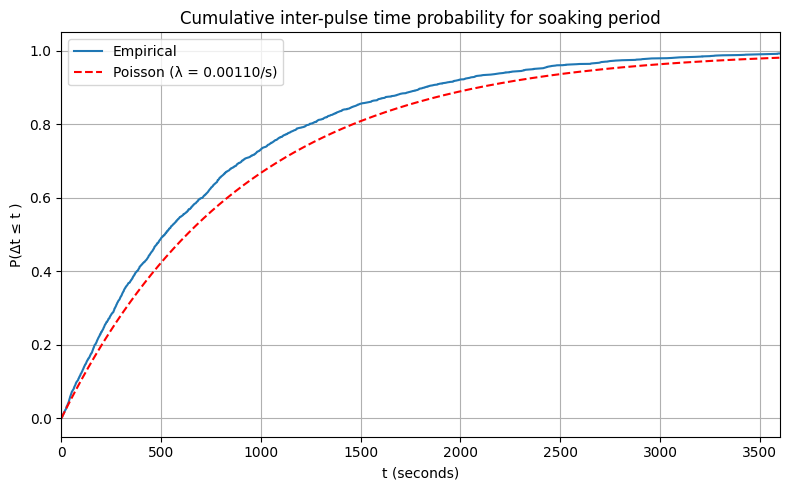

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(soaking_delta_sorted, soaking_P_exp, label="Empirical")
plt.plot(soaking_delta_sorted, soaking_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {soaking_lam:.5f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
plt.xlim([0,3600])
plt.title("Cumulative inter-pulse time probability for soaking period")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution looks poisson, but the distribution mean looks higher than the calculated mean.

There are a few gaps in the data when data collection was interrupted. We can exclude these gaps and see if these outliers are dragging down the mean.

In [43]:
#Drop soaking deltas greater than 6 hours
soaking_delta_sorted = soaking_delta_sorted[soaking_delta_sorted < 6*60*60]

# Estimate lambda for soaking period (rate in events per second)
soaking_lam = 1 / np.mean(soaking_delta_sorted)

# Calculate the theoretical distribution
soaking_P_poisson = 1 - np.exp(-soaking_lam * soaking_delta_sorted)

soaking_P_exp = np.arange(1, len(soaking_delta_sorted) + 1) / len(soaking_delta_sorted)

In [44]:
soaking_lam

np.float64(0.0013048322849575746)

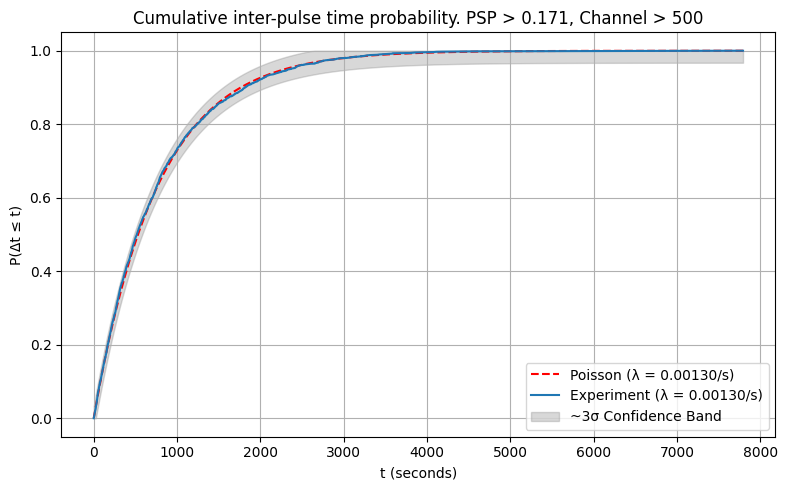

In [50]:
# Number of samples (n)
n = len(soaking_delta_sorted)

# Desired confidence level (e.g. ~3σ = 99.7%)
alpha = 0.003# Kolmogorov–Smirnov critical value for given alpha and n
D_alpha = np.sqrt(-0.5 * np.log(alpha / 2) / n)


# Upper and lower bounds of the confidence band
upper_bound = np.clip(soaking_P_poisson + D_alpha, 0, 1)
lower_bound = np.clip(soaking_P_poisson - D_alpha, 0, 1)

plt.figure(figsize=(8, 5))
plt.plot(soaking_delta_sorted, soaking_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {soaking_lam:.5f}/s)")
plt.plot(soaking_delta_sorted, soaking_P_exp, label=f"Experiment (λ = {soaking_lam:.5f}/s)")
plt.fill_between(soaking_delta_sorted, lower_bound, upper_bound, color='gray', alpha=0.3, label="~3σ Confidence Band", zorder=1)

#plt.axvline(experiment_delta_sorted[first_cross_index], color='purple', linestyle=':', label="Statistical significance achieved")


plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
#plt.xlim([0,1])
#plt.ylim([0,0.6])
plt.title(f"Cumulative inter-pulse time probability. PSP > {psp}, Channel > {energy}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

With the large gaps excluded, the inter-pulse time for the soaking period is well fit by a Poisson distribution.

Now let's check the laser period.

In [46]:
laser_neutron_data = experiment_neutron_data["Begin laser"]
laser_deltas = np.diff(laser_neutron_data.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
laser_delta_sorted = np.sort(laser_deltas)

In [47]:
# Estimate lambda for laser period (rate in events per second)
laser_lam = 1 / np.mean(laser_delta_sorted)

# Calculate the theoretical distribution
laser_P_poisson = 1 - np.exp(-laser_lam * laser_delta_sorted)

laser_P_exp = np.arange(1, len(laser_delta_sorted) + 1) / len(laser_delta_sorted)

In [48]:
laser_lam

np.float64(0.0013122027268799013)

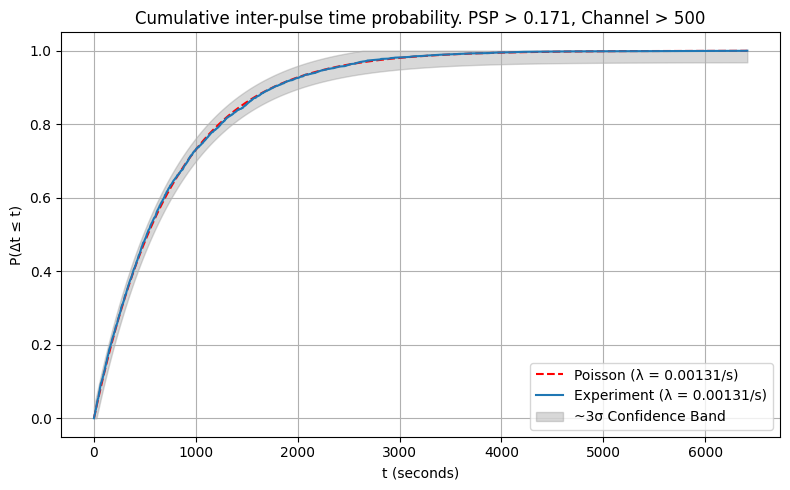

In [51]:
# Number of samples (n)
n = len(laser_delta_sorted)

# Desired confidence level (e.g. ~3σ = 99.7%)
alpha = 0.003# Kolmogorov–Smirnov critical value for given alpha and n
D_alpha = np.sqrt(-0.5 * np.log(alpha / 2) / n)


# Upper and lower bounds of the confidence band
upper_bound = np.clip(laser_P_poisson + D_alpha, 0, 1)
lower_bound = np.clip(laser_P_poisson - D_alpha, 0, 1)

plt.figure(figsize=(8, 5))
plt.plot(laser_delta_sorted, laser_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {laser_lam:.5f}/s)")
plt.plot(laser_delta_sorted, laser_P_exp, label=f"Experiment (λ = {laser_lam:.5f}/s)")
plt.fill_between(laser_delta_sorted, lower_bound, upper_bound, color='gray', alpha=0.3, label="~3σ Confidence Band", zorder=1)

#plt.axvline(experiment_delta_sorted[first_cross_index], color='purple', linestyle=':', label="Statistical significance achieved")


plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
#plt.xlim([0,1])
#plt.ylim([0,0.6])
plt.title(f"Cumulative inter-pulse time probability. PSP > {psp}, Channel > {energy}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()